2024-12-18 09:37:47.200564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734514667.216429 3262753 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734514667.221279 3262753 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 09:37:47.241299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180371 entries, 0 to 180370
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 180371 non-null  int64  
 1   dur                180371 non-null  float64
 2   proto              180371 non-null  object 
 3   service            180371 non-null  object 
 4   state              180371 non-null  object 
 5   spkts              180371 non-null  int64  
 6   dpkts              180371 non-null  int64  
 7   sbytes             180371 non-null  int64  
 8   dbytes             180371 non-null  int64  
 9   rate               180371 non-null  float64
 10  sttl               180371 non-null  int64  
 11  dttl               180371 non-null  int64  
 12  sload              180371 non-null  float64
 13  dload              180371 non-null  float64
 14  sloss              180371 non-null  int64  
 15  dloss              180371 non-null  

/tmp/ipykernel_3262753/432265042.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


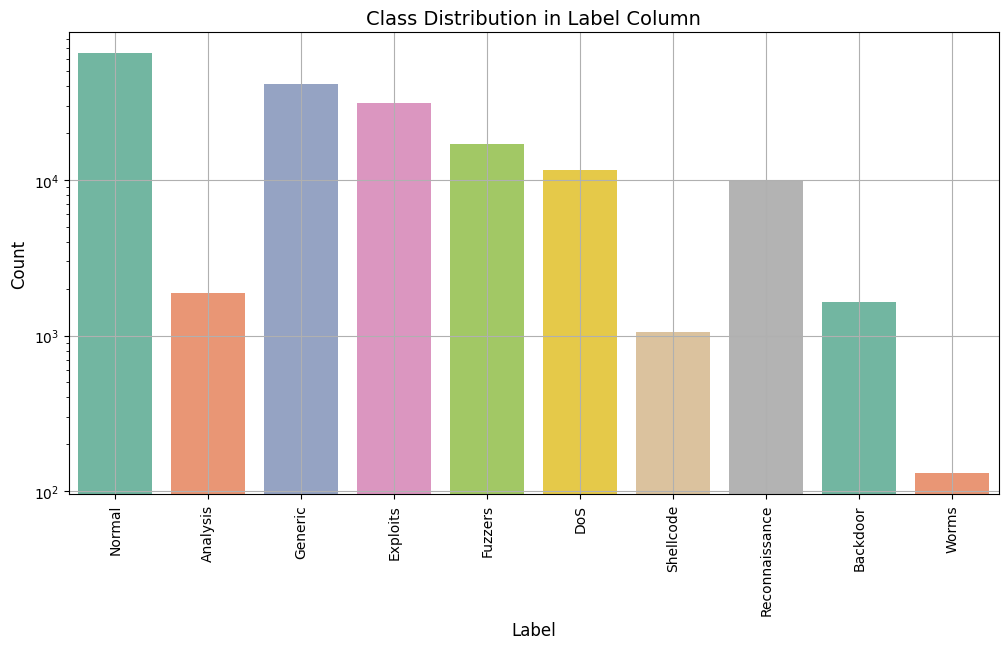

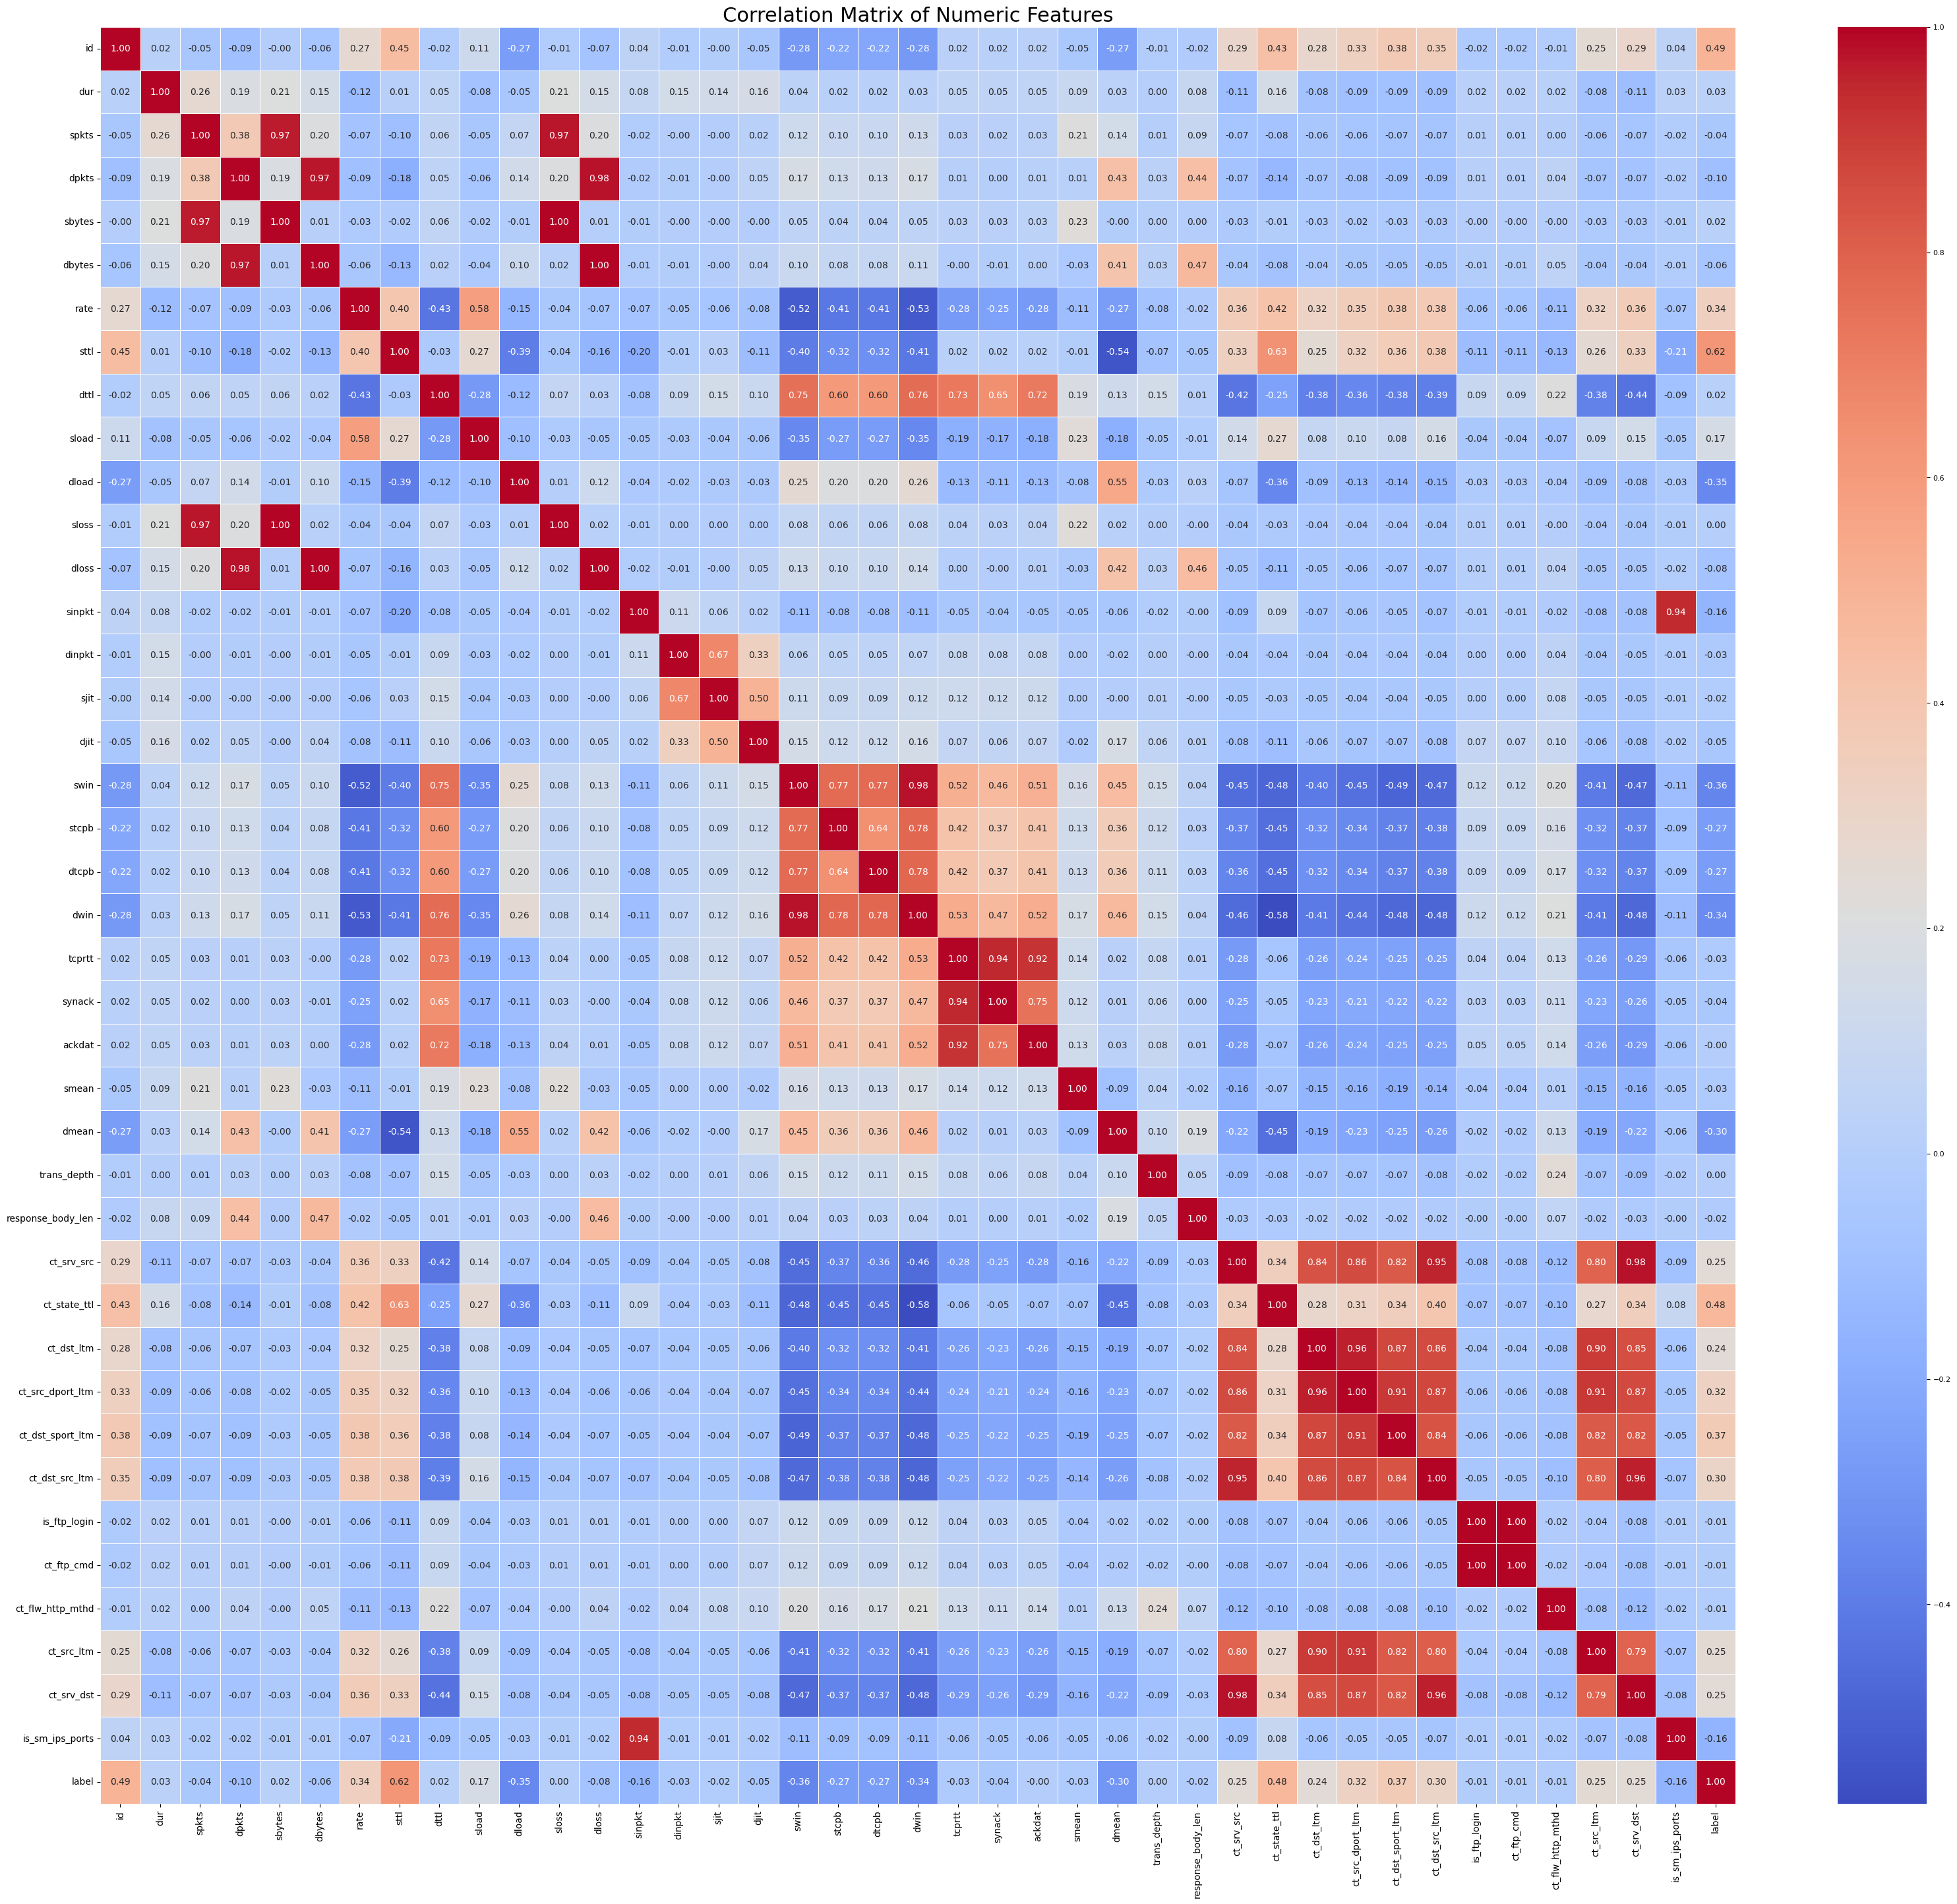

In [1]:
import import_ipynb
%run UNSW_NB15_data_preprocessing.ipynb


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class TimeNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, kernel_size=3, num_filters=64, dropout=0.5, dilation_rates=[1, 2, 4]):
        super(TimeNet, self).__init__()

        # Step 1: Temporal Convolutional Layers for feature extraction
        # Adjust padding to match the dilation
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, stride=1, padding=(dilation_rates[0] * (kernel_size - 1)) // 2, dilation=dilation_rates[0])  # Dilated convolution
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, stride=1, padding=(dilation_rates[1] * (kernel_size - 1)) // 2, dilation=dilation_rates[1])
        self.conv3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=kernel_size, stride=1, padding=(dilation_rates[2] * (kernel_size - 1)) // 2, dilation=dilation_rates[2])

        # Step 2: Residual Connections (skip connections)
        self.residual1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=1, stride=1, padding=0)
        self.residual2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=1, stride=1, padding=0)
        self.residual3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=1, stride=1, padding=0)

        # Step 3: Fully connected layers (for classification)
        self.fc1 = nn.Linear(num_filters * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Ensure input shape is [batch_size, channels, length]
        
        # Apply temporal convolution layers with residual connections
        res1 = self.residual1(x)  # Residual connection for the first layer
        x = self.conv1(x) + res1  # Adding residual to the convolution output
        x = torch.relu(x)
        
        res2 = self.residual2(x)  # Residual connection for the second layer
        x = self.conv2(x) + res2  # Adding residual to the convolution output
        x = torch.relu(x)
        
        res3 = self.residual3(x)  # Residual connection for the third layer
        x = self.conv3(x) + res3  # Adding residual to the convolution output
        x = torch.relu(x)

        # Step 3: Flatten the output for fully connected layers
        x = x.mean(dim=2)  # Global average pooling to reduce dimensionality (seq_len dimension)

        # Step 4: Use fully connected layers
        x = torch.relu(self.fc1(x))  # [batch_size, hidden_dim]
        x = self.dropout(x)
        x = self.fc2(x)  # [batch_size, num_classes]

        return x


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels, patience=5):
    num_classes = len(labels)
    input_dim = X_train.shape[1]
    model = TimeNet(input_dim=input_dim, num_classes=num_classes).to(device)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, threshold=1e-6, min_lr=1e-6)

    # Reshape the data for Conv1d (adding channel dimension)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (samples, 1, input_dim)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long).to(device))
    val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.long).to(device))
    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Early stopping variables
    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_weights = None

    # Training loop
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_accuracy = correct / total
        val_loss /= len(val_loader)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {running_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_weights = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs with no improvement in validation accuracy.")
            break

    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Evaluate on the test set
    model.eval()
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(targets.tolist())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    test_accuracy = correct / total

    # Print test set accuracy
    print(f"UNSW_NB15_TimeNet_accuracy: {test_accuracy:.6f}")

    return model, labels, y_true, y_pred


# Call the function
model, labels, y_test_true, y_test_pred = train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels)


Epoch 1, Loss: 765.784064, Validation Loss: 0.131777, Validation Accuracy: 0.972574, Learning Rate: 0.001000
Epoch 2, Loss: 85.217828, Validation Loss: 0.202939, Validation Accuracy: 0.968745, Learning Rate: 0.001000
Epoch 3, Loss: 67.092145, Validation Loss: 0.065688, Validation Accuracy: 0.982898, Learning Rate: 0.001000
Epoch 4, Loss: 30.846877, Validation Loss: 0.102099, Validation Accuracy: 0.937956, Learning Rate: 0.001000
Epoch 5, Loss: 18.249447, Validation Loss: 0.012294, Validation Accuracy: 0.997025, Learning Rate: 0.001000
Epoch 6, Loss: 24.449649, Validation Loss: 0.013750, Validation Accuracy: 0.994463, Learning Rate: 0.001000
Epoch 7, Loss: 14.179035, Validation Loss: 0.003989, Validation Accuracy: 0.999560, Learning Rate: 0.001000
Epoch 8, Loss: 28.771379, Validation Loss: 0.055172, Validation Accuracy: 0.990453, Learning Rate: 0.001000
Epoch 9, Loss: 7.813461, Validation Loss: 0.012964, Validation Accuracy: 0.996041, Learning Rate: 0.001000
Epoch 10, Loss: 13.550478, V

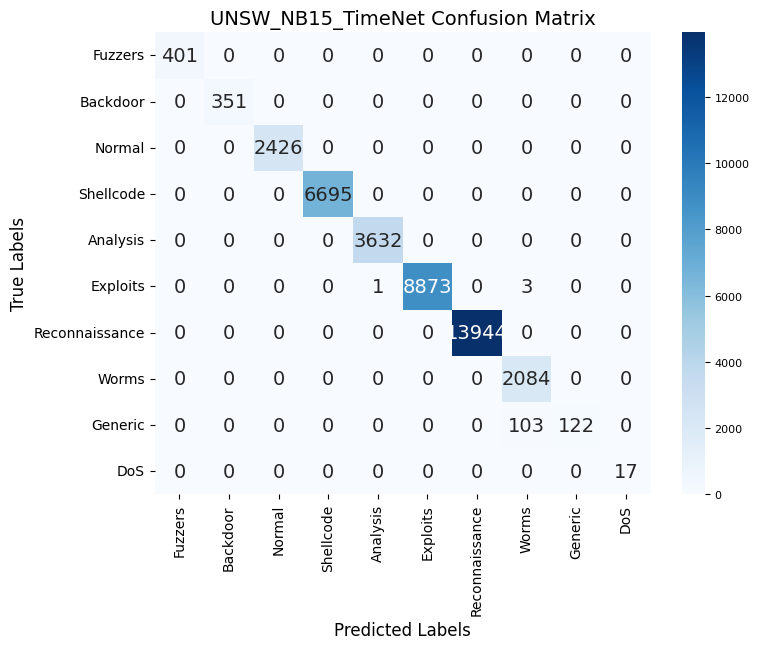

UNSW_NB15_TimeNet Classification Report:
                precision    recall  f1-score   support

       Fuzzers       1.00      1.00      1.00       401
      Backdoor       1.00      1.00      1.00       351
        Normal       1.00      1.00      1.00      2426
     Shellcode       1.00      1.00      1.00      6695
      Analysis       1.00      1.00      1.00      3632
      Exploits       1.00      1.00      1.00      8877
Reconnaissance       1.00      1.00      1.00     13944
         Worms       0.95      1.00      0.98      2084
       Generic       1.00      0.54      0.70       225
           DoS       1.00      1.00      1.00        17

      accuracy                           1.00     38652
     macro avg       1.00      0.95      0.97     38652
  weighted avg       1.00      1.00      1.00     38652



In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting confusion matrix for Meta Model
cm_meta = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_meta, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})
plt.title("UNSW_NB15_TimeNet Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.show()

print("UNSW_NB15_TimeNet Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=labels))
